In [1]:
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from concurrent.futures import ThreadPoolExecutor
from mtcnn import MTCNN
import os
from tqdm import tqdm
from rich import print

In [2]:
size = (224, 224)
classes = ['Autistic', 'Non_Autistic']
detector = MTCNN()

Exception ignored in: <_io.BufferedReader>
Traceback (most recent call last):
  File "C:\Users\habib\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\lz4\frame\__init__.py", line 753, in flush
    self._fp.flush()
ValueError: I/O operation on closed file.
Exception ignored in: <_io.BufferedReader>
Traceback (most recent call last):
  File "C:\Users\habib\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\lz4\frame\__init__.py", line 753, in flush
    self._fp.flush()
ValueError: I/O operation on closed file.
Exception ignored in: <_io.BufferedReader>
Traceback (most recent call last):
  File "C:\Users\habib\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\lz4\frame\__init__.py", line 753, in flush
    self._fp.flush()
ValueError: I/O operation on closed file.


In [3]:
def align_face(image, keypoints):
    left_eye = keypoints['left_eye']
    right_eye = keypoints['right_eye']

    dy = right_eye[1] - left_eye[1]
    dx = right_eye[0] - left_eye[0]
    angle = np.degrees(np.arctan2(dy, dx))

    h, w = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    return cv2.warpAffine(image, M, (w, h))


In [4]:
def crop_face(image, box, margin=0.3):
    x, y, w, h = box

    size = int(max(w, h) * (1 + margin))
    cx, cy = x + w // 2, y + h // 2

    x1 = max(cx - size // 2, 0)
    y1 = max(cy - size // 2, 0)
    x2 = min(cx + size // 2, image.shape[1])
    y2 = min(cy + size // 2, image.shape[0])

    return image[y1:y2, x1:x2]


In [70]:
def ld_img(path):
    img = cv2.imread(path)
    if img is None:
        return None

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    detections = detector.detect_faces(img)
    if not detections:
        return None

    face_img = crop_face(align_face(img, detections[0]['keypoints']), detections[0]['box'])
    if face_img.size == 0:
        return None

    face_img = cv2.resize(face_img, size) / 255.0

    folder_name = os.path.basename(os.path.dirname(path))
    label = classes.index(folder_name) if folder_name in classes else -1

    return face_img, label


def ld(folder_path, max_workers=8):
    paths = glob.glob(os.path.join(folder_path, '**', '*.[jp][pn][g]'), recursive=True)
    
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        results = list(tqdm(executor.map(ld_img, paths), total=len(paths), desc="Read"))

    results = [r for r in results if r is not None]
    
    images, labels = zip(*results) if results else ([], [])
    print(f'Loaded {len(images)} images from {folder_path}')
    return np.array(images), np.array(labels)

In [6]:
X_train, y_train = ld('datasets/AutismDataset/train')
X_val, y_val = ld('datasets/AutismDataset/valid')
X_test, y_test = ld('datasets/AutismDataset/test')

Read: 100%|██████████| 2540/2540 [10:08<00:00,  4.17it/s]


Loaded 2505 images from datasets/AutismDataset/train

Read: 100%|██████████| 100/100 [00:26<00:00,  3.73it/s]


Loaded 97 images from datasets/AutismDataset/valid

Read: 100%|██████████| 300/300 [01:13<00:00,  4.07it/s]


Loaded 298 images from datasets/AutismDataset/test

In [20]:
print(f'{X_train.shape} {y_train.shape} {X_val.shape} {y_val.shape} {X_test.shape} {y_test.shape}')

(2504, 224, 224, 3) (2504,) (96, 224, 224, 3) (96,) (298, 224, 224, 3) (298,)

In [19]:
X_train, y_train, X_val, y_val = np.delete(X_train, 1, axis=0), np.delete(y_train, 1, axis=0), np.delete(X_val, 1, axis=0), np.delete(y_val, 1, axis=0)

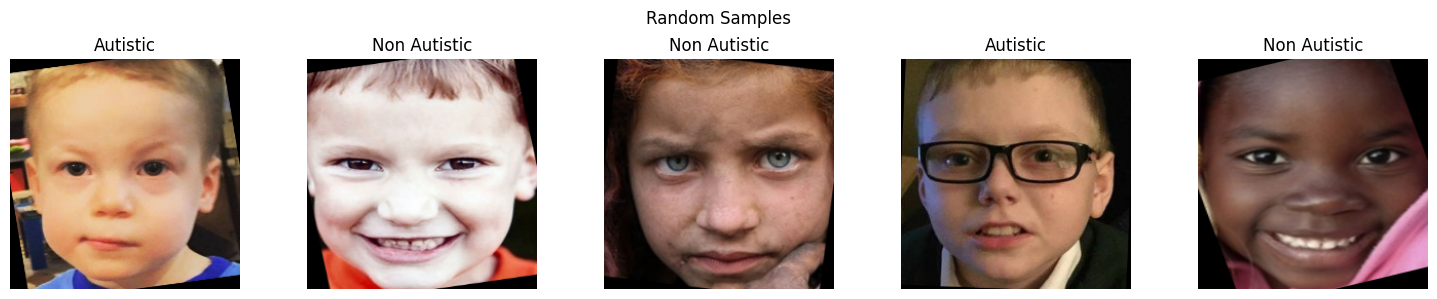

In [22]:
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, ax in enumerate(axes):
    idx = np.random.randint(0, len(X_train))
    ax.imshow(X_train[idx])
    ax.set_title(f"{'Autistic' if y_train[idx] == 0 else 'Non Autistic'}")
    ax.axis('off')
plt.suptitle('Random Samples')
plt.tight_layout()
plt.show()

In [23]:
print(X_train.shape)

(2504, 224, 224, 3)

In [24]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

In [25]:
model = keras.Sequential([
    layers.Input(shape=(size[0], size[1], 3)),
    layers.Conv2D(24, 3, activation='relu'),
    layers.MaxPooling2D(2),
    layers.Conv2D(32, 2, activation='relu'),
    layers.MaxPooling2D(2),
    layers.Conv2D(64, 1, activation='relu'),
    layers.MaxPooling2D(2),
    layers.Flatten(),
    layers.Dense(1, activation='sigmoid')
])

In [26]:
early_stop = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

In [27]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 24)   │           672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 24)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 110, 110, 32)   │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 55, 55, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 55, 55, 64)     │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 27, 27, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 46656)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │        46,657 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,545 (205.25 KB)

 Trainable params: 52,545 (205.25 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
y_train.shape # ??

(2504,)

In [110]:
from sklearn.model_selection import train_test_split
_, X_val, _, y_val = train_test_split(X_train, y_train, test_size=0.5, random_state=42)

In [111]:
print(X_val.shape, y_val.shape, X_train.shape, y_train.shape)

(1270, 224, 224, 3)
(1270,)
(2540, 224, 224, 3)
(2540,)

In [29]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32, verbose=1, callbacks=[early_stop])

Epoch 1/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 26s 297ms/step - accuracy: 0.5543 - loss: 0.6833 - val_accuracy: 0.6875 - val_loss: 0.6600
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 27s 337ms/step - accuracy: 0.6569 - loss: 0.6389 - val_accuracy: 0.6667 - val_loss: 0.5956
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 26s 327ms/step - accuracy: 0.6809 - loss: 0.5900 - val_accuracy: 0.7396 - val_loss: 0.5651
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 27s 346ms/step - accuracy: 0.7001 - loss: 0.5702 - val_accuracy: 0.6667 - val_loss: 0.5918
Epoch 5/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 25s 321ms/step - accuracy: 0.7089 - loss: 0.5581 - val_accuracy: 0.7292 - val_loss: 0.5471
Epoch 6/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 25s 319ms/step - accuracy: 0.7236 - loss: 0.5393 - val_accuracy: 0.7396 - val_loss: 0.5527
Epoch 7/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 27s 338ms/step - accuracy: 0.7372 - loss: 0.5336 - val_accuracy: 0.7188 - val_loss: 0.5364
Epoch 8/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 26s 330ms/step - accuracy: 0.7444 - loss: 0.5207 - val_accu

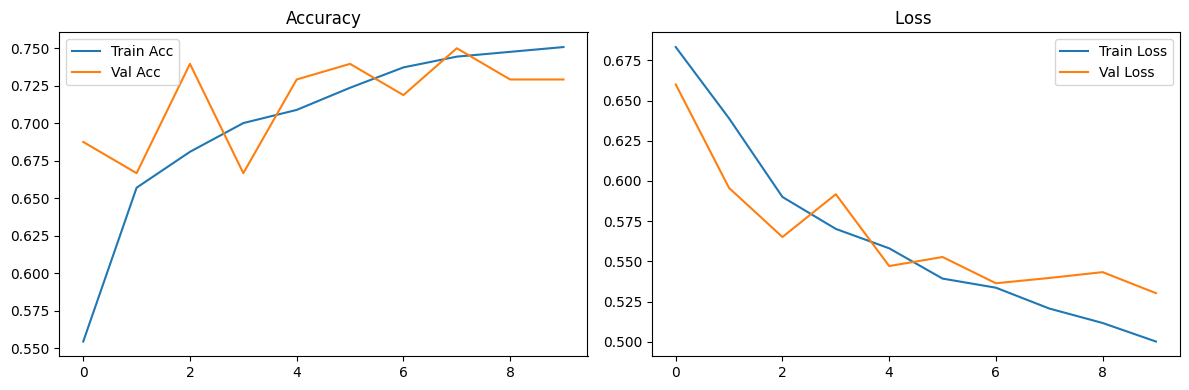

In [30]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(history.history['accuracy'], label='Train Acc')
ax1.plot(history.history['val_accuracy'], label='Val Acc')
ax1.set_title('Accuracy')
ax1.legend()
ax2.plot(history.history['loss'], label='Train Loss')
ax2.plot(history.history['val_loss'], label='Val Loss')
ax2.set_title('Loss ')
ax2.legend()
plt.tight_layout()
plt.show()

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step


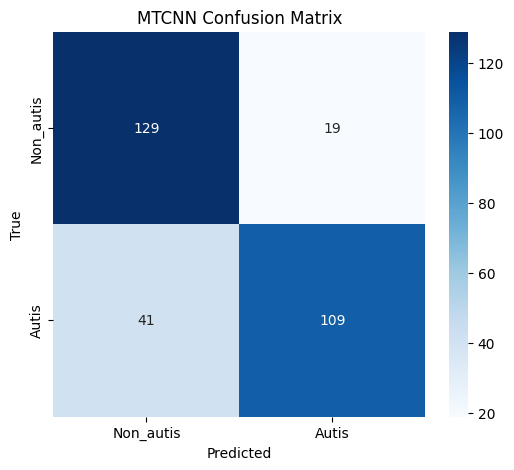

In [69]:
y_pred = (model.predict(X_test) > 0.5).astype(int).flatten()
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non_autis', 'Autis'], yticklabels=['Non_autis', 'Autis'])
plt.title('MTCNN Confusion Matrix')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

In [32]:
print('\nClassification Report:')
print(classification_report(y_test, y_pred, target_names=['Non_autis', 'Autis']))

Classification Report:

precision    recall  f1-score   support

   Non_autis       0.76      0.87      0.81       148
       Autis       0.85      0.73      0.78       150

    accuracy                           0.80       298
   macro avg       0.81      0.80      0.80       298
weighted avg       0.81      0.80      0.80       298

In [65]:
idx = np.random.randint(0, len(X_test))
print(X_test[idx].shape)

(224, 224, 3)

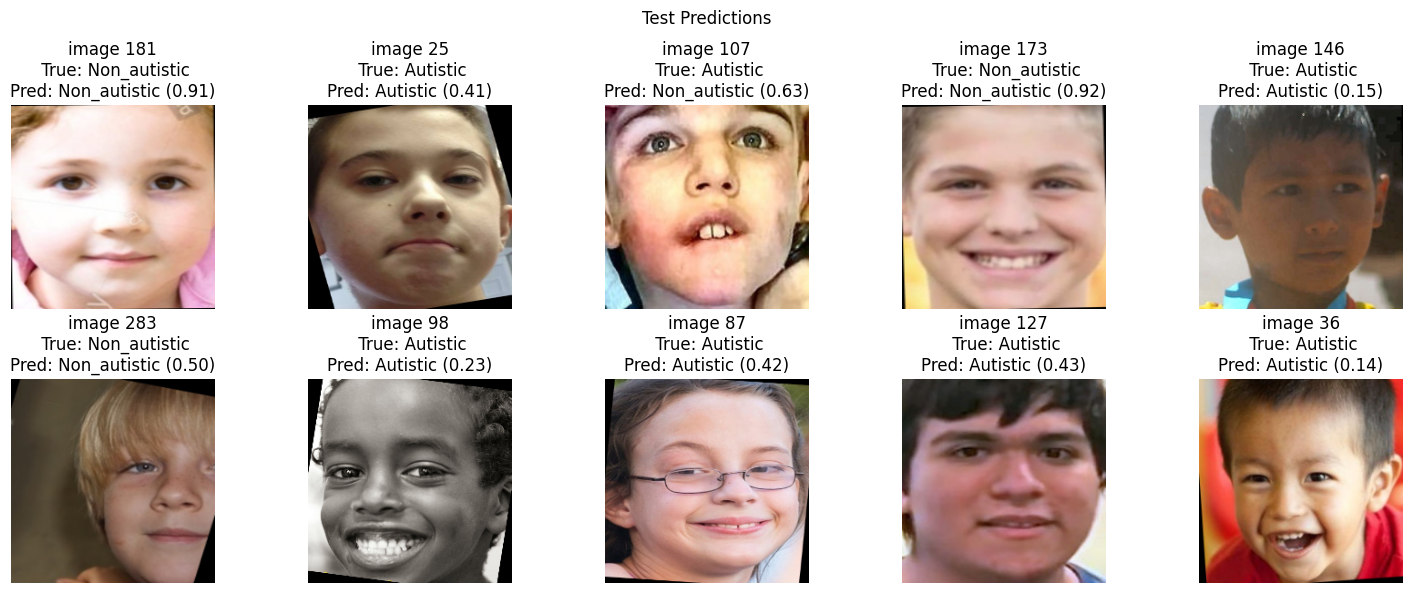

In [67]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for ax in axes.flat:
    idx = np.random.randint(0, len(X_test))
    pred = model.predict(X_test[idx:idx+1], verbose=None)[0][0]
    ax.imshow(X_test[idx])
    ax.set_title(f"image {idx}\n True: {'Autistic' if y_test[idx] == 0 else 'Non_autistic'}\nPred: {'Autistic' if pred < 0.5 else 'Non_autistic'} ({pred:.2f})")
    ax.axis('off')
plt.suptitle('Test Predictions')
plt.tight_layout()
plt.show()

In [68]:
model.save('model/autism_cnn_model(MTCNN).h5')